In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import torch

%config InlineBackend.figure_format = 'retina'

### Load and summarize the data

In [2]:
seqs = pd.read_csv("oas_pair_heavy.csv", usecols=["cdr3_aa_heavy"])[
    "cdr3_aa_heavy"
].tolist()
seqs = list(set(seqs))
seqs[:10]

['ARYWGSLFDY',
 'ARRLDYFDY',
 'ARDNFNDNSLLYAMDV',
 'AHSVGYYGYNRGYFDY',
 'TRPDYWYFDF',
 'TQEAANWAFAY',
 'AKDGYPYSSSWGNSYFDY',
 'ARGASGYVGFAY',
 'ATLYVYYGSYGDY',
 'ARWAWHGQLSA']

95% CI: [6.000, 22.000]
101344 sequences, min length 2, max length 44


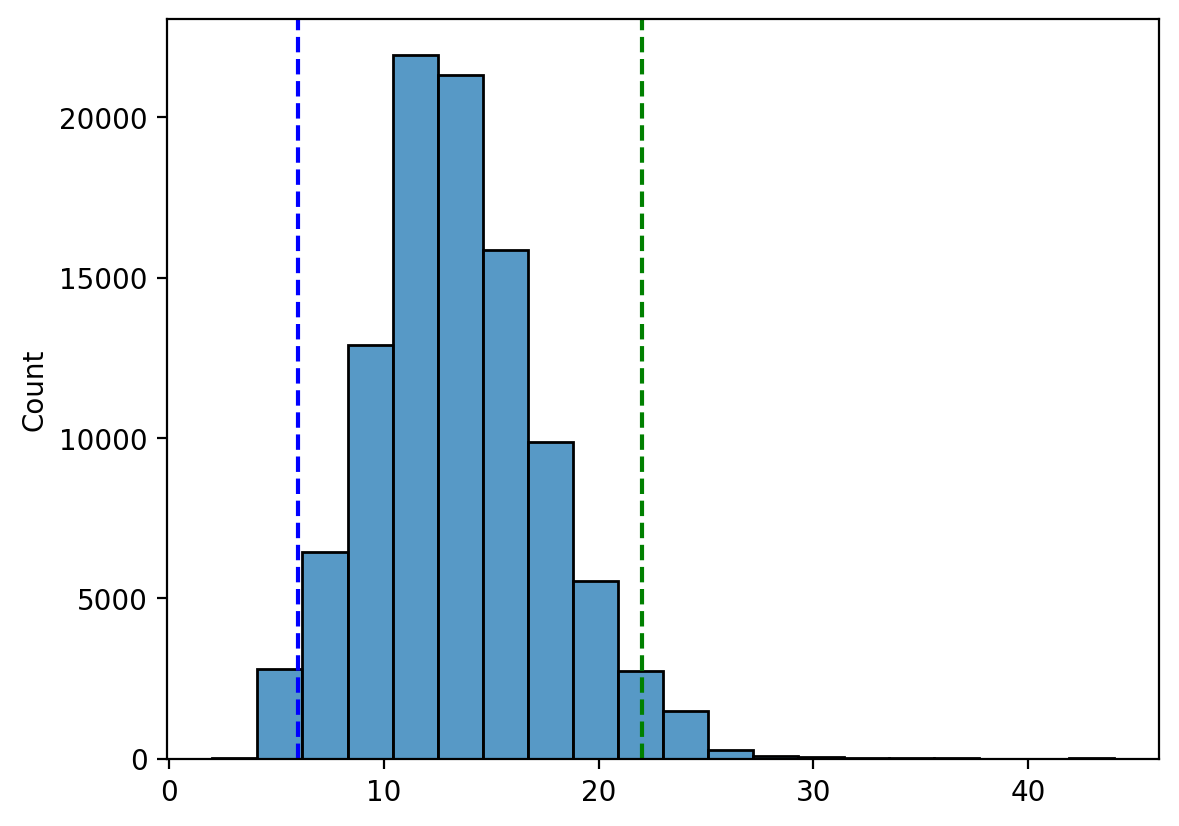

In [3]:
lengths = [len(seq) for seq in seqs]
total = len(seqs)
min_len = min(lengths)
max_len = max(lengths)
lower = np.percentile(lengths, 2.5)
upper = np.percentile(lengths, 97.5)
print(f"95% CI: [{lower:.3f}, {upper:.3f}]")
print(f"{total} sequences, min length {min_len}, max length {max_len}")
sns.histplot(lengths, bins=20, kde=False, stat="count")
plt.axvline(lower, color="blue", linestyle="--", label="2.5% (Lower)")
plt.axvline(upper, color="green", linestyle="--", label="97.5% (Upper)")
plt.show()

### N-grams

In [4]:
def ngrams_count(seqs, n):
    ngrams = {}
    for seq in seqs:
        seq = ["<S>"] + list(seq) + ["<E>"]
        for i in range(len(seq) - n + 1):
            ngram = tuple(seq[i : i + n])
            ngrams[ngram] = ngrams.get(ngram, 0) + 1
    ngrams = dict(sorted(ngrams.items(), key=lambda kv: -kv[1]))
    return ngrams

### Bigrams

In [5]:
bigrams = ngrams_count(seqs, n=2)

In [6]:
tokens = ["<S>"] + sorted(list(set("".join(seqs)))) + ["<E>"]
stoi = {t: i for i, t in enumerate(tokens)}
itos = {i: t for t, i in stoi.items()}

In [7]:
def bigrams_matrix(bigrams, tokens):
    n = len(tokens)
    N = torch.zeros((n, n), dtype=torch.int32)
    for i, t1 in enumerate(tokens):
        for j, t2 in enumerate(tokens):
            N[i, j] = bigrams.get((t1, t2), 0)
    return N

In [8]:
N = bigrams_matrix(bigrams, tokens)
print(f"{N.shape} matrix")
# One of the most common starting motif of CDRH3
N[stoi["A"], stoi["R"]]

torch.Size([22, 22]) matrix


tensor(63466, dtype=torch.int32)

In [9]:
def plot_bigrams(N, tokens, itos):
    plt.figure(figsize=(16, 16))
    plt.imshow(N, cmap="Blues")
    for i in range(len(tokens)):
        for j in range(len(tokens)):
            cnt = N[i, j].item()
            text = "".join((itos[i], itos[j]))
            plt.text(j, i, cnt, ha="center", va="top", color="gray")
            plt.text(
                j,
                i,
                text,
                ha="center",
                va="bottom",
                color="gray",
                fontdict={"fontsize": 8},
            )
    plt.axis("off")
    plt.show()

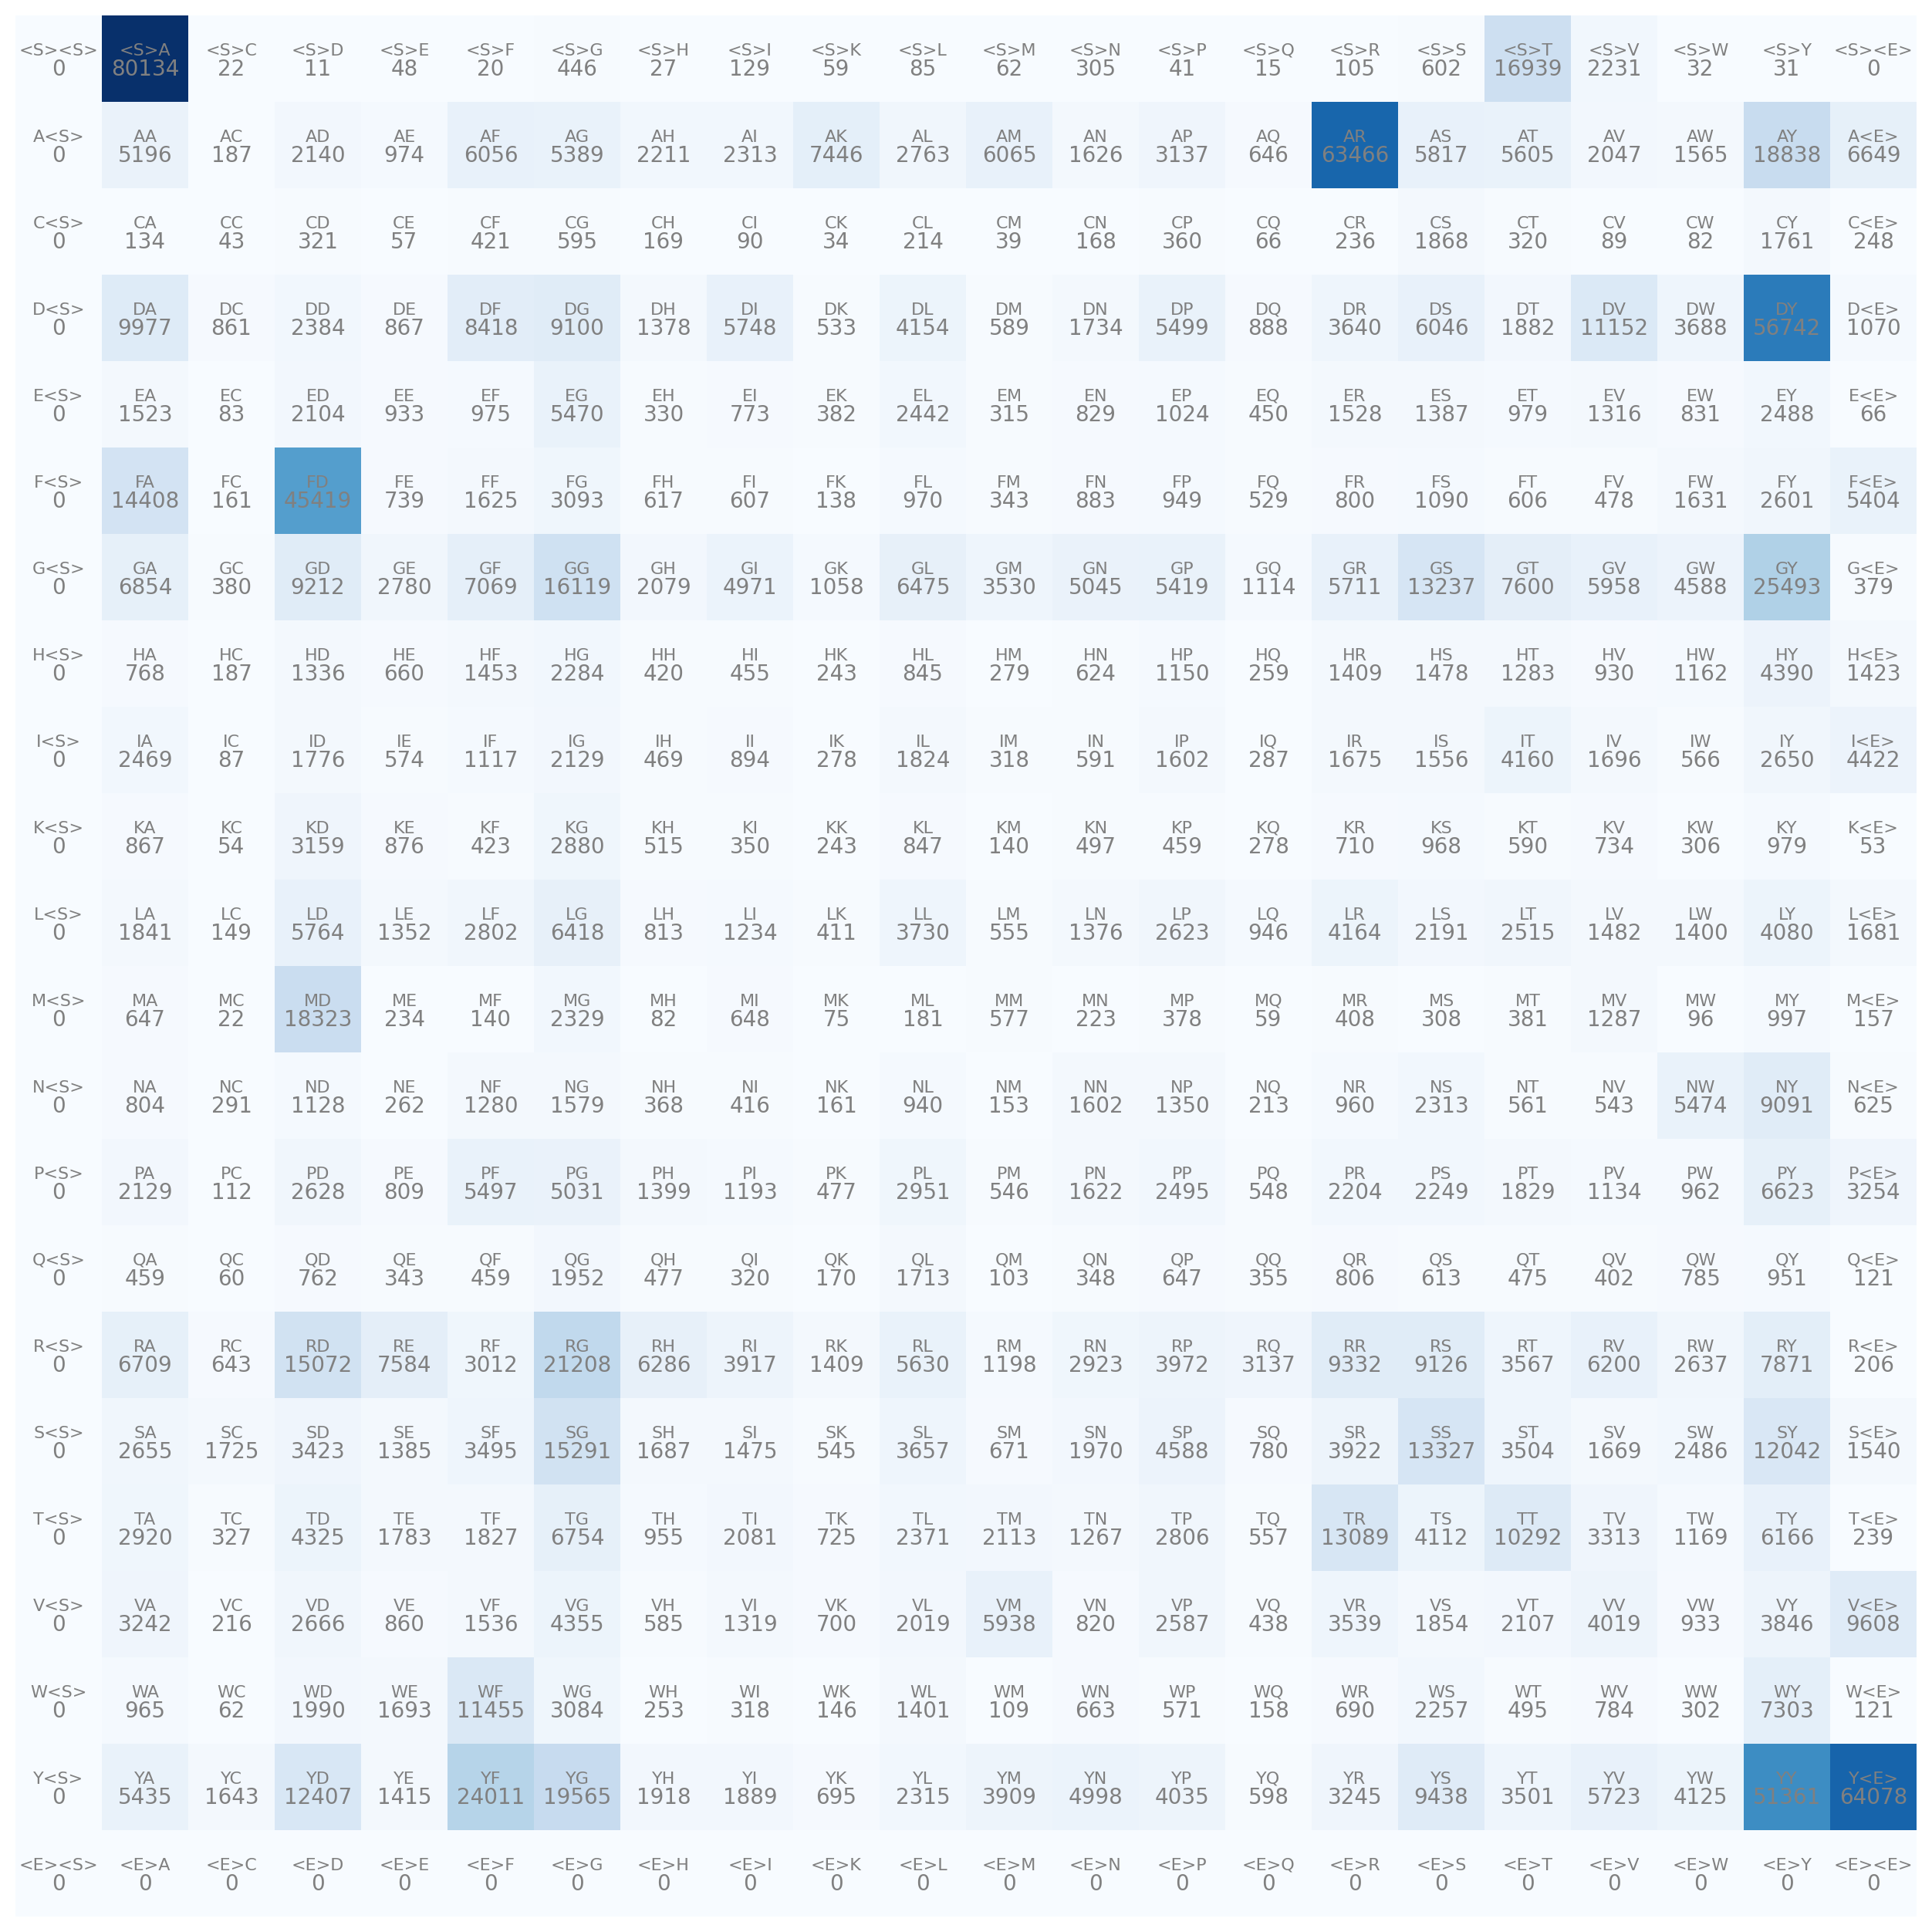

In [10]:
plot_bigrams(N, tokens, itos)

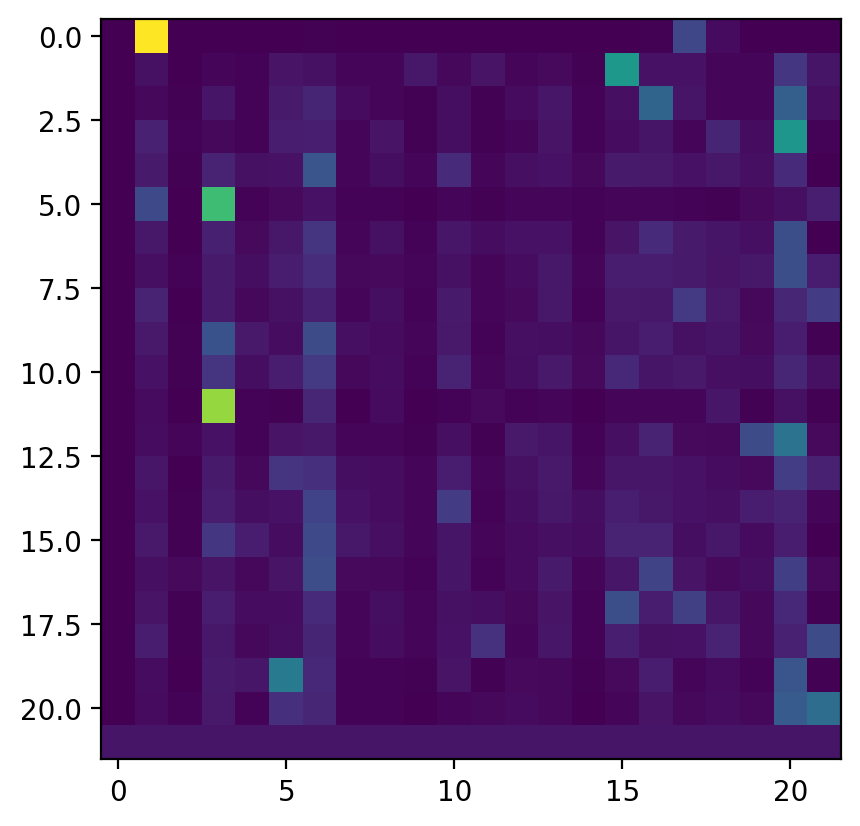

In [11]:
P = (
    N + 1
).float()  # add 1 to smoothing probabilities and make sure below generated abnormal seq can be calculated
P /= P.sum(1, keepdim=True)

plt.imshow(P)

### Sampling

In [12]:
def exists(tensor):
    return tensor is not None

In [13]:
def sampling_one_step(start_id: int, generator=None, probs_matrix=None) -> str:
    if exists(probs_matrix):
        prob = probs_matrix[start_id]
    else:
        prob = torch.ones(len(stoi))
        prob /= prob.sum()

    ix = torch.multinomial(
        prob, num_samples=1, replacement=True, generator=generator
    ).item()
    return ix

In [14]:
# Sampling next token using uniform dist
start_aa = "<S>"
start_id = stoi[start_aa]
next_id = sampling_one_step(start_id)
next_aa = itos[next_id]
print(next_aa)

# Sampling next token using bigram probs dist
start_aa = "<S>"
start_id = stoi[start_aa]
next_id = sampling_one_step(start_id, probs_matrix=P)
next_aa = itos[next_id]
print(next_aa)

G
A


In [15]:
def sampling_one_seq(start_id, generator=None, probs_matrix=None, eos_token_id=None):
    token_ids = [start_id]
    while True:
        next_id = sampling_one_step(
            start_id, generator=generator, probs_matrix=probs_matrix
        )
        token_ids.append(next_id)
        if next_id == eos_token_id:
            break
        start_id = next_id
    return token_ids

In [16]:
start_aa = "<S>"
start_id = stoi[start_aa]
sampled_ids = sampling_one_seq(
    start_id=start_id, generator=None, probs_matrix=P, eos_token_id=stoi["<E>"]
)
sampled_seq = "".join([itos[id] for id in sampled_ids])
sampled_seq

'<S>ARIYFDYYTNSLDYGPDY<E>'

In [17]:
def sampling_batch_seqs(
    sample_size=10, probs_matrix=None, stoi={}, itos={}, seed=2147483647
):
    generator = torch.Generator().manual_seed(seed)
    sampled_seqs = []

    start_aa = "<S>"
    end_aa = "<E>"

    start_id = stoi[start_aa]
    for i in range(sample_size):
        sampled_ids = sampling_one_seq(
            start_id=start_id,
            generator=generator,
            probs_matrix=probs_matrix,
            eos_token_id=stoi[end_aa],
        )
        sampled_seq = "".join([itos[id] for id in sampled_ids[1:-1]])
        sampled_seqs.append(sampled_seq)
    return sampled_seqs

In [18]:
sampling_batch_seqs(sample_size=10, probs_matrix=P, stoi=stoi, itos=itos)

['ALDNWSSY',
 'AKPTDLNLP',
 'TIAARFDDYFDLGIN',
 'AASRHY',
 'ATSYYYYPHYAGYY',
 'ARSY',
 'ARVTIFDLWGTGLLKY',
 'ARSFWFDYCPLI',
 'ARGLARLFDYYGITPGYDVMGYSSYLGFPDLRPRLSQEY',
 'ARDGYNNNQSSY']

### Metric
Goal: Define a metric to evalute the performance of language model

Using [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) theory
> *Reference: This is achieved by maximizing a likelihood function so that, under the assumed statistical model, the observed data is most probable*

- maximize likelihood of the data w.r.t. model paprameters
- equivalent to maximize the log likelihood(because log is monotonic)
- equivalent to minimize the negtive log likelihood
- equivalent to minimize the average negtive log likelihood

In [19]:
def seq2tokens(seq: str):
    token_list = []
    seq = seq.replace("<S>", "^").replace("<E>", "$")
    for token in seq:
        if token == "^":
            token_list.append("<S>")
        elif token == "$":
            token_list.append("<E>")
        else:
            token_list.append(token)
    return token_list

In [20]:
seq = "ARQEYA<S>PMDA"
seq2tokens(seq)

['A', 'R', 'Q', 'E', 'Y', 'A', '<S>', 'P', 'M', 'D', 'A']

In [21]:
def negtive_log_likelihood(seq: str, n=2, stoi={}, P=None) -> torch.tensor:
    token_list = seq2tokens(seq)
    token_list = ["<S>"] + token_list + ["<E>"]
    log_likelihood = 0.0
    total = 0
    for i in range(len(token_list) - n + 1):
        assert n == 2, "Only support Bigrams."
        ch1, ch2 = token_list[i : i + n]
        id1, id2 = stoi[ch1], stoi[ch2]
        P = P if exists(P) else torch.ones(len(stoi), len(stoi)) / len(stoi)
        log_likelihood += torch.log(P[id1, id2])
        total += 1

    nll = -log_likelihood / total
    return nll

In [22]:
seq = "<S>ARQE<E>YAPMDA"
negtive_log_likelihood(seq, n=2, stoi=stoi, P=P)

tensor(3.6220)

In [23]:
def evaluate(sample_size=10, probs_matrix=None, stoi={}, itos={}, seed=2147483647):
    for seq in sampling_batch_seqs(
        sample_size=sample_size,
        probs_matrix=probs_matrix,
        stoi=stoi,
        itos=itos,
        seed=seed,
    ):
        nll = negtive_log_likelihood(seq, stoi=stoi, P=P)
        print(f"{''.join(seq)} ==> {nll:.4f}")

In [24]:
# sampling using uniform probs and evaluating using bigram probs
evaluate(probs_matrix=None, stoi=stoi, itos=itos)

DL<S>NWMDYWGDPTDLNLPNCKHACFRDQV<S>LGIC ==> 4.1987
FAS ==> 4.3644
HY ==> 3.7049
ITSYYYVPHMAGYKMRETKMSRVTIFCEW<S>TGLLKC<S>L ==> 3.9688
WFWAYLCPLII ==> 3.6650
CGLELLFDNCGIWPGMDRKGKS ==> 3.3242
LLFFPDLCPRMIQEN ==> 3.9353
DRVGYN<S>NQSSD ==> 4.4250
LLLGAC ==> 3.8874
SCF<S>KDCET ==> 5.1075


In [25]:
# sampling using bigram probs and evaluating using bigram probs
evaluate(probs_matrix=P, stoi=stoi, itos=itos)

ALDNWSSY ==> 2.2377
AKPTDLNLP ==> 2.8814
TIAARFDDYFDLGIN ==> 2.5475
AASRHY ==> 2.2530
ATSYYYYPHYAGYY ==> 2.2234
ARSY ==> 1.3729
ARVTIFDLWGTGLLKY ==> 2.5744
ARSFWFDYCPLI ==> 2.2802
ARGLARLFDYYGITPGYDVMGYSSYLGFPDLRPRLSQEY ==> 2.4898
ARDGYNNNQSSY ==> 2.3216
